# Getting started with fine tuning with TerraTorch

TerraTorch is a package that allows you to easily use and fine tune geospatial foundation models (GeoFMs). This tutorial walks through how to get started with TerraTorch to fine tune a GeoFM on your own data and task, whatever that may be. 

Achieving fine tuning and inference using TerraTorch can be achieved in four steps: 
1. **Organize your data:** Make sure your inputs, labels, and spits are organized in a standardized way that TerraTorch generic DataModules can interpret
2. **Set up your DataModule:** Use TerraTorch generic DataModules to create an object which reads in your data, makes any necessary adjustments, and passes it to your model in the format it expects for training.
3. **Set up your Task:** Identify your chosen task, choose your model and define hyperparemeters
4. **Train your model:** Use Pytorch Lightning to handle training and logging for a set number of epochs.

In this demo, we will show how to fine tune Prithvi on a subset of the EuroSAT benchmark, which classifies 64x64 pixel Sentinel 2 L1C images into one of 10 classes. The demo is written in a general way to help users adapt this code to their specific use case. 

## Step 0: Setup

### HuggingFace cache

Because we are on a shared server with shared conda environment, we need to reorient where huggingface downloads things like model weights and datasets

In [1]:
import os
import pathlib

# Specify where you want model weights/datasets to be saved
DATA_PATH = 'home/waves/generalist_vs_specialized_geoAI'

# Set up environment variables that are used by HuggingFace
os.environ["HF_HOME"] = os.path.join(DATA_PATH, "hfhome")
os.environ["HF_HUB_CACHE"] = os.path.join(DATA_PATH, "hub")
os.environ["HF_DATASETS_CACHE"] = os.path.join(DATA_PATH, "datasets")
os.environ["TRANSFORMERS_CACHE"] = os.path.join(DATA_PATH, "transformers")

## Step 1: Get your data in the right format for TerraTorch

TerraTorch makes your life easier if you organize your data in standard ways. Specifically, following these conventions will allow you to use their generic DataModules and save your the trouble of writing your own. 


### File organization

* **Classification:** Organize your images into different folders depending on their class (this is how EuroSAT is organized). Alternatively, have a metadata file listing 
* **Segmentation/regression:** Have images and their labels (masks or continuous outputs) have the same name but followed by an image vs. mask or label identifier (e.g. image: `Im_1_img.tif` and `Im_1_mask.tif`

#### EuroSAT classification example

We can retrieve a subsample of the EuroSAT dataset using torchgeo. Luckily, we will show it is already in the format TerraTorch expects for a classification task. 

In [2]:
from torchgeo.datasets import EuroSAT100 # 100 image subset from EuroSAT

EuroSAT100(
    root=DATA_PATH, # make sure you have defined the path where you want data saved
    split='train',
    download=True,
)

EuroSAT100(
    root=DATA_PATH, 
    split='val',
    download=True,
)

EuroSAT100(
    root=DATA_PATH, 
    split='test',
    download=True,
)

Dataset EuroSAT100
    Number of datapoints: 20
    Root location: home/waves/generalist_vs_specialized_geoAI/ds/images/remote_sensing/otherDatasets/sentinel_2/tif

When opening inspecting the downloaded dataset, you will find that the data will be stored at the following path: 

In [3]:
# Define the location of the saved EUROSAT data
EUROSAT = DATA_PATH + "/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/"

There is one folder for each class, each containing `.tif` files with the images to be classified. 

In [4]:
# List the folders each containing images for a given EuroSAT class
from pathlib import Path

class_paths = [item for item in Path(EUROSAT).iterdir()]
class_names = [item.name for item in class_paths]
print(class_names)

['AnnualCrop', 'Pasture', 'Residential', 'SeaLake', 'River', 'PermanentCrop', 'Industrial', 'Forest', 'HerbaceousVegetation', 'Highway']


### Specify splits

To specify which images belong to which split, you have two options: 
* provide `.txt` files that have the names of the images in each split in them
* organize the splits into different folders

#### EuroSAT example

In the case of EuroSAT, the names of the images belonging to each split are saved as `.txt` files. 

In [5]:
# Save the paths to each split for use in the DataModule setup

TRAIN_SPLIT = DATA_PATH + '/eurosat-100-train.txt'
VAL_SPLIT = DATA_PATH + '/eurosat-100-val.txt'
TEST_SPLIT = DATA_PATH + '/eurosat-100-test.txt'

## Step 2: Get your DataModule set up

### Inspect your data

It is important to have a good grasp of the contents of your data in order to set up the DataModule properly. It can therefore be useful to do a bit of exploration and visualization. 

In [6]:
# Read in the first image in each class for inspection

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# get the first image in each class
image_sample = [next(folder.iterdir()) for folder in class_paths] # list of 10 images

# read all 10 sample images
ims = [rasterio.open(image).read() for image in image_sample]

#### Image statistics

By inspecting the first image, we find that we have 13 bands per image (corresponding to the 13 Sentinel-2 L1C bands) and images are 64x64 pixels. Neither of these is what Prithvi expects, so it's important to know this so we can adjust it in the DataLoader. 

We also note that the units are in reflectance values. 

In [7]:
# print some statistics for the first image
print("Shape:", ims[1].shape)
print("Means by band:", ims[1].mean(axis=(1,2)))
print("Stds by band:", ims[1].std(axis=(1,2)))

Shape: (13, 64, 64)
Means by band: [1111.91015625  878.35302734  860.88916016  561.85717773 1049.72314453
 2990.7590332  3927.78759766 3768.70898438  784.35449219    9.52734375
 1921.38916016  893.63745117 4360.02270508]
Stds by band: [ 66.17921288 144.33596733 161.69847222 289.04565891 205.60533486
 520.52450006 818.25824945 877.48558976 117.80382851   1.07153073
 484.48251268 473.27016809 892.61514993]


#### Visualization

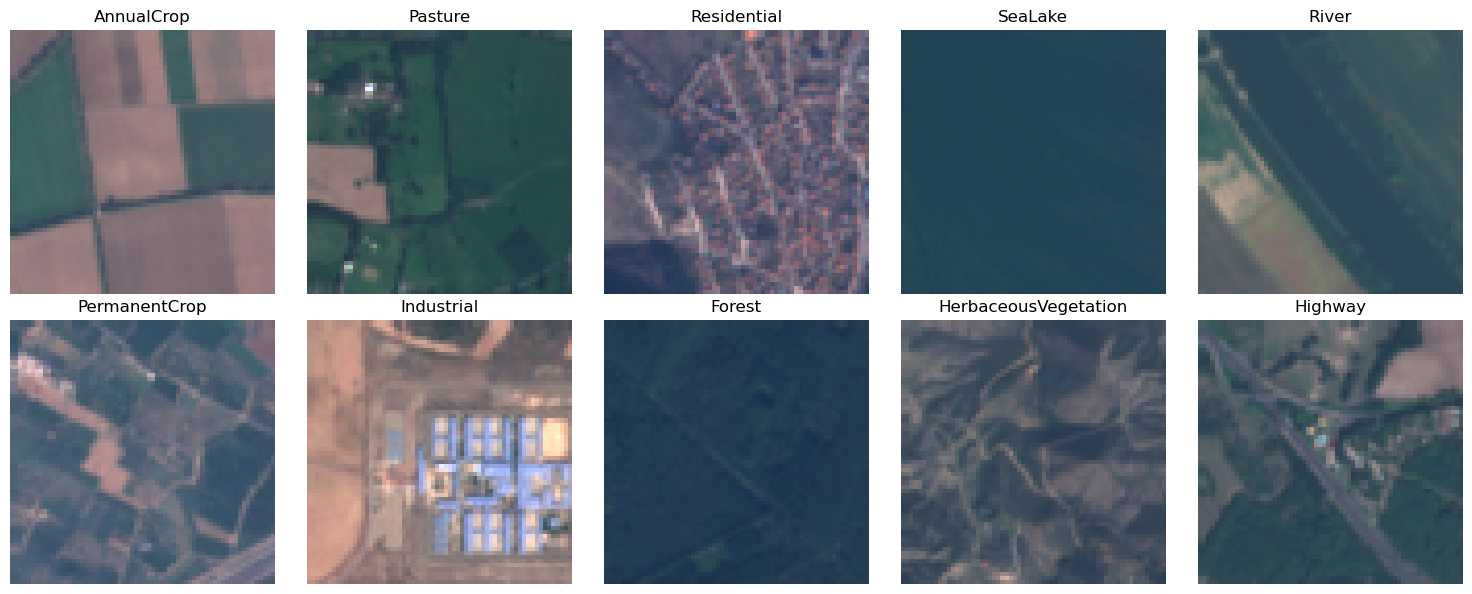

In [8]:
def to_rgb(img):

    # select the r,g,b bands
    rgb = img[[3,2,1]].astype(float)

    # Follow EuroSAT guidelines for visualization
    # clip to a max of 2750
    # normalize to 0-1
    rgb = np.clip(rgb, 0, 2750) / 2750

    # go from (CxWxH) to (WxHxC)
    rgb = np.transpose(rgb, (1,2,0))
    
    return rgb

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, (ax, img, name) in enumerate(zip(axes, ims, class_names)):
    rgb = to_rgb(img)
    ax.imshow(rgb)
    ax.set_title(name)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Define bands, statistics, and transforms

There are a few important parameters we will need to define when setting up our DataModule in addition to the location of the data and splits that we defined in Step 1. 

We specifically use the GenericNonGeoClassificationDataModule, though all generic DataModules will need these inputs. You can always learn more about the arguments for a given DataModule by adapting the following code: 

```{python}
from terratorch.datamodules import GenericNonGeoClassificationDataModule
?GenericNonGeoClassificationDataModule
```

#### Band names
We need to tell the datamodule which bands we actually want to go into the model. 

In our case, we have 13 sentinel 2 bands, but Prithvi is trained on 6 landsay bands, so we need to subset them. 

In [9]:
sentinel2_bands = [
    "B1", "B2", "B3", "B4", "B5", "B6", "B7",
    "B8", "B8A", "B9", "B10", "B11", "B12"
]

# The subset of our bands Prithvi will take
prithvi_subset = [1, 2, 3, 8, 11, 12]
prithvi_bands = [sentinel2_bands[i] for i in prithvi_subset]
print(prithvi_bands)

['B2', 'B3', 'B4', 'B8A', 'B11', 'B12']


#### Means and standard deviations

We need band-level means and standard deviations. Either compute them yourself over your entire dataset, or get general numbers that work well for your data type. 

We have S2 L1C data. We can use TerraMesh statistics I grabbed from their huggingface: https://huggingface.co/api/resolve-cache/datasets/ibm-esa-geospatial/TerraMesh/6c548cdacdd70e98a236de9f5b708d4b9dadf253/terramesh.py

In [10]:
statistics = {
    "mean": {
        "S2L1C": [2357.090, 2137.398, 2018.799, 2082.998, 2295.663, 2854.548, 3122.860, 3040.571, 3306.491, 1473.849,
                  506.072, 2472.840, 1838.943],
        "S2L2A": [1390.461, 1503.332, 1718.211, 1853.926, 2199.116, 2779.989, 2987.025, 3083.248, 3132.235, 3162.989,
                  2424.902, 1857.665],
        "S2RGB": [110.349, 99.507, 75.843],
        "S1GRD": [-12.577, -20.265],
        "S1RTC": [-10.93, -17.329],
        "NDVI": [0.327],
        "DEM": [651.663],
    },
    "std": {
        "S2L1C": [1673.639, 1722.641, 1602.205, 1873.138, 1866.055, 1779.839, 1776.496, 1724.114, 1771.041, 1079.786,
                  512.404, 1340.879, 1172.435],
        "S2L2A": [2131.157, 2163.666, 2059.311, 2152.477, 2105.179, 1912.773, 1842.326, 1893.568, 1775.656, 1814.907,
                  1436.282, 1336.155],
        "S2RGB": [69.905, 53.708, 53.378],
        "S1GRD": [5.179, 5.872],
        "S1RTC": [4.391, 4.459],
        "NDVI": [0.322],
        "DEM": [928.168]
    }
}

We specifically need to pass Sentinel 2 L1C means and stds, but only for the 6 bands we are subsetting for input into prithvi.

In [11]:
S2L1C_prithvi_means = [statistics["mean"]["S2L1C"][i] for i in prithvi_subset]
S2L1C_prithvi_stds = [statistics["std"]["S2L1C"][i] for i in prithvi_subset]
print(S2L1C_prithvi_means)
print(S2L1C_prithvi_stds)

[2137.398, 2018.799, 2082.998, 3306.491, 2472.84, 1838.943]
[1722.641, 1602.205, 1873.138, 1771.041, 1340.879, 1172.435]


#### Transforms

Transforms allow you to make changes to your data on the fly before feeding them to a model for training. There are three important types of transforms: 
* Reshaping/resizing/clipping: To get your data into the shape your model expects. 
* Data augmentations: If you don't have a lot of training data, you can "augment" your dataset by presenting changed versions of your images to the model. For example, flip your images. This type of transform generally should only happen to your training data, and not your validation and testing data. 
* Make your image a tensor (the data format that GPUs can use)

We can use albumentations to do any of these. 

In [12]:
import albumentations

train_transforms = albumentations.Compose([
    albumentations.Resize(224, 224), # go from 64x64 to 224x224 (Prithvi expected size)
    albumentations.HorizontalFlip(), # augmentation
    albumentations.pytorch.transforms.ToTensorV2(),
])

# Same transforms but without augmentations for validation and testing
val_test_transforms = albumentations.Compose([
    albumentations.Resize(224, 224), 
    albumentations.pytorch.transforms.ToTensorV2(),
])

### Define your DataModule

In [13]:
from terratorch.datamodules import GenericNonGeoClassificationDataModule

datamodule = GenericNonGeoClassificationDataModule(
    batch_size=16, # How many images to give the model at once. More = faster, but more RAM is needed
    num_workers=0, # extra CPU threads for image loading

    # Where is our data? In our case, all splits are in the same folder
    train_data_root=EUROSAT, 
    val_data_root=EUROSAT, 
    test_data_root=EUROSAT, 

    # Because images for all splits are in the same place, we need to specify our split files
    train_split=TRAIN_SPLIT,
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,

    # means and standard deviations for the bands being input into the model
    means=S2L1C_prithvi_means, 
    stds=S2L1C_prithvi_stds,

    # number of classes
    num_classes=len(class_names),

    # Tranforms, defined using albumentations
    train_transform=train_transforms,
    val_transform=val_test_transforms,
    test_transform=val_test_transforms,

    # Bands of our dataset
    dataset_bands=sentinel2_bands,
    # Bands to input into our model
    output_bands=prithvi_bands,
)

datamodule.setup("fit")

/home/g288kc/miniforge/envs/geoAI/lib/python3.11/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/g288kc/miniforge/envs/geoAI/lib/python3.11/site-packages/albumentations/core/composition.py:465: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  super().__init__(


### Check your DataModule

To ensure that the data are as we would expect the model to find them, we can manually iterate through a batch of the datamodule to inspect it. 

In [14]:
batch = next(iter(datamodule.train_dataloader()))

More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples per pixel than can be decoded: 13
More samples 

In [15]:
print(f"Batch keys: {batch.keys()}")
print(f"Image shape: {batch['image'].shape}")
print(f"Label shape: {batch['label'].shape if 'label' in batch else batch['labels'].shape}")

# Check the actual values
print(f"\nImage dtype: {batch['image'].dtype}")
print(f"Image min/max: {batch['image'].min()}, {batch['image'].max()}")
print(f"Labels: {batch['label'] if 'label' in batch else batch['labels']}")

Batch keys: dict_keys(['image', 'label', 'filename'])
Image shape: torch.Size([16, 6, 224, 224])
Label shape: torch.Size([16])

Image dtype: torch.float32
Image min/max: 40.142860412597656, 11904.0712890625
Labels: tensor([8, 8, 3, 0, 5, 6, 7, 6, 1, 0, 5, 7, 6, 7, 2, 5])


As expected, we have 16 images with 6 bands and resized to the width and height the model expects. 

Notice the min and max have not been normalized. This is because normalization occurs during every training and validation step, which happens below. 

## Step 3: Get your Task set up

TerraTorch has several Lightning Trainers to easily handle model training, and has Tasks defined for each major task type. We will be using the ClassificationTask. 

These Tasks are where you can define your model choice and model hyperparameters. 

### Choose your model from the model factory

If you don't know which model you would like to use, you can explore what is available in TerraTorch's model factory. 

#### Explore encoders

In [16]:
from terratorch.registry import BACKBONE_REGISTRY

# List all the available backbones from different sources
for name, source in BACKBONE_REGISTRY._sources.items():
    print(f"\n===={name}=====")
    print(list(source))


====terratorch=====
['dofa_small_patch16_224', 'dofa_base_patch16_224', 'dofa_large_patch16_224', 'prithvi_eo_tiny', 'prithvi_eo_v1_100', 'prithvi_eo_v2_tiny_tl', 'prithvi_eo_v2_100_tl', 'prithvi_eo_v2_300', 'prithvi_eo_v2_600', 'prithvi_eo_v2_300_tl', 'prithvi_eo_v2_600_tl', 'terramind_v1_base', 'terramind_v1_base_tim', 'terramind_v01_base', 'terramind_v01_base_tim', 'terramind_v1_large', 'terramind_v1_large_tim', 'terramind_v1_tiny', 'terramind_v1_tiny_tim', 'terramind_v1_small', 'terramind_v1_small_tim', 'terramind_v1_tokenizer_s2l2a', 'terramind_v1_tokenizer_s1rtc', 'terramind_v1_tokenizer_s1grd', 'terramind_v1_tokenizer_dem', 'terramind_v1_tokenizer_lulc', 'terramind_v1_tokenizer_ndvi', 'ssl4eol_resnet18_landsat_tm_toa_moco', 'ssl4eol_resnet18_landsat_tm_toa_simclr', 'ssl4eol_resnet18_landsat_etm_toa_moco', 'ssl4eol_resnet18_landsat_etm_toa_simclr', 'ssl4eol_resnet18_landsat_etm_sr_moco', 'ssl4eol_resnet18_landsat_etm_sr_simclr', 'ssl4eol_resnet18_landsat_oli_tirs_toa_moco', 'ssl

In [17]:
# let's just list out the Prithvi models in the terratorch source

print([mod for mod in BACKBONE_REGISTRY._sources['terratorch'] if 'prithvi' in mod])

['prithvi_eo_tiny', 'prithvi_eo_v1_100', 'prithvi_eo_v2_tiny_tl', 'prithvi_eo_v2_100_tl', 'prithvi_eo_v2_300', 'prithvi_eo_v2_600', 'prithvi_eo_v2_300_tl', 'prithvi_eo_v2_600_tl']


There are many different prithvi versions to select from -- for this demo we will choose the smaller `prithvi_eo_v1_100`. 

#### Explore decoders

In [18]:
from terratorch.registry import DECODER_REGISTRY

# Check available decoders
for name, source in DECODER_REGISTRY._sources.items():
    print(f"\n===={name}=====")
    print(list(source))


====terratorch=====
['ASPPModule', 'ASPPHead', 'ASPPSegmentationHead', 'ASPPRegressionHead', 'FCNDecoder', 'IdentityDecoder', 'LinearDecoder', 'MLPDecoder', 'SatMAEHead', 'UNetDecoder', 'UperNetDecoder']

====smp=====
['PAN', 'DeepLabV3', 'PSPNet', 'UPerNet', 'Linknet', 'FPN', 'MAnet', 'Unet', 'UnetPlusPlus', 'Segformer', 'DeepLabV3Plus']


We choose the FCNDecoder because it is good for Classification tasks. 

### Define your Task

In [20]:
from terratorch.tasks import ClassificationTask

task = ClassificationTask(

    # Define your model
    model_factory="EncoderDecoderFactory", # TerraTorch's EncoderDecoderFactory, where we found our models
    model_args={
        'backbone': 'prithvi_eo_v1_100', # Smaller Prithvi model for demo
        'backbone_pretrained': True, # Train from scratch or use pre-trained weights? 
        'decoder': 'FCNDecoder', # Chosen decoder for classification
        'num_classes': len(class_names),
    },

    # What would you like to train? 
    freeze_backbone=True, # Do not update prithvi weights for demo
    freeze_decoder=False, # Train the decoder
    
    # Optionally, change hyperparameters from the defaults
    loss='ce', 
    lr=1e-4
)

## Step 4: Train your model

Now that we have our Task and DataModule, we can easily use PyTorch Lightning to train our model. 

We also use Weights and Biases to check our progress during training. 

In [ ]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar, LearningRateMonitor

# Initialize callbacks
# Save the best and the last model
checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
# Stop training if validation metrics stop improving for a certain number of epochs
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)

# Check your progress and results during training using Weights and Biases. 
# You'll have to make an account but it's very useful. 
# Just click the link it gives you to watch your training progress plotted in real time. 
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(log_model="all") 

# Define your Trainer
trainer = Trainer(
    devices=1, # Number of GPUs. Interactive mode recommended with 1 device
    precision="16-mixed", # Use 16-bit floats as opposed to 32-bit (higher precision) when it's safe to save on time and memory
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        early_stopping_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=wandb_logger,
    max_epochs=100, # Train for up to 100 epochs
    default_root_dir='output/tutorial', # where checkpoints/logs go.
    log_every_n_steps=1, 
    check_val_every_n_epoch=1 # How frequently to calcualte validation performance
)

# Fit your model!
_ = trainer.fit(model=task, datamodule=datamodule)

/home/g288kc/miniforge/envs/geoAI/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/g288kc/miniforge/envs/geoAI/lib/python3.11/sit ...
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: boseranna (boseranna-university-of-california-santa-barbara) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ ScalarOutputModel │ 90.2 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss  │      0 │ train │
│ 2 │ train_metrics │ MetricCollection  │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection  │      0 │ train │
│ 4 │ test_metrics  │ ModuleList        │      0 │ train │
└───┴───────────────┴───────────────────┴────────┴───────┘

Trainable params: 3.9 M                                                                                            
Non-trainable params: 86.2 M                                                                                       
Total params: 90.2 M                                                                                               
Total estimated model params size (MB): 360                                                                        
Modules in train mode: 335                                                                                         
Modules in eval mode: 0

Output()

ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel th

/home/g288kc/miniforge/envs/geoAI/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to 
errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)

/home/g288kc/miniforge/envs/geoAI/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 
The ``compute`` method of metric MulticlassF1Score was called before the ``update`` method which may lead to 
errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)

ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 13
ERROR:PIL.TiffImagePlugin:More samples per pixel th